# Model Selection and Testing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

## Baseline model

In [2]:
df_mf_train = pd.read_csv('../Data/df_mf_train.csv')
df_mf_test = pd.read_csv('../Data/df_mf_test.csv')

In [3]:
df_mf_train.head()

,Ticker,Morningstar Risk,Morningstar Sustainability Rating,3-year Mean Dividend Yield (%),% of Holdings in Cash,Price/Earnings,Price/Cash Flow,Average Market Cap ($ mil),ROE Last Year (%),Debt/Capital Last Year (%),...,% Assets in Top 10 Holdings,Turnover Ratio (%),Average Manager Tenure (years),Expense Ratio (%),Minimum Initial Purchase ($),Total Assets ($ mil),3-year Annualized Return vs. S&P500,Outperform / Underperform,Yes,Yes.1
0,VFTNX,3,4,1.45,0.01,23.37,17.87,183202,28.22,45.19,...,30.13,18,5,0.12,5000000,10798,4.48,1,1,0
1,JCNNX,4,1,1.80,1.04,22.70,16.71,19870,10.25,48.60,...,44.05,68,4,0.58,1000000,3785,7.61,1,1,0
2,PMJPX,3,4,0.68,0.25,13.47,4.15,1830,0.62,46.75,...,12.57,202,6,0.63,1000000,552,-4.02,0,1,0
3,WMICX,5,2,2.78,2.15,30.72,17.52,1264,-6.53,30.18,...,25.07,75,10,1.66,2000,1410,23.85,1,1,0
4,STAEX,3,3,2.02,1.92,34.27,24.58,178923,24.25,45.50,...,47.94,16,8,1.02,1000,287,9.69,1,0,0


In [4]:
X_train_base = df_mf_train.drop(['Ticker','3-year Annualized Return vs. S&P500','Outperform / Underperform'], axis=1)
y_train_base = df_mf_train['Outperform / Underperform']

X_test_base = df_mf_test.drop(['Ticker','3-year Annualized Return vs. S&P500','Outperform / Underperform'], axis=1)
y_test_base = df_mf_test['Outperform / Underperform']

### Logistic regression

In [5]:
scaler = StandardScaler()

In [6]:
X_train_base_scaled = scaler.fit_transform(X_train_base)
X_test_base_scaled = scaler.transform(X_test_base)

In [7]:
logmodel = LogisticRegression()
logmodel.fit(X_train_base_scaled,y_train_base)

LogisticRegression()

In [8]:
logmodel.score(X_test_base_scaled, y_test_base)

0.9709302325581395

In [9]:
pred_log = logmodel.predict(X_test_base_scaled)

In [10]:
print(confusion_matrix(y_test_base, pred_log))

[[667  13]
 [ 22 502]]


In [11]:
print(classification_report(y_test_base, pred_log))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       680
           1       0.97      0.96      0.97       524

    accuracy                           0.97      1204
   macro avg       0.97      0.97      0.97      1204
weighted avg       0.97      0.97      0.97      1204



#### Gridsearch

In [12]:
param_grid = {'penalty': ['l1','l2'], 'C': [0.1,1, 10, 100, 1000]} 

In [13]:
grid = GridSearchCV(LogisticRegression(),param_grid,refit=True,n_jobs=-1,verbose=2)

In [14]:
grid.fit(X_train_base_scaled,y_train_base)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
             verbose=2)

In [15]:
grid.best_params_

{'C': 10, 'penalty': 'l2'}

In [16]:
grid.score(X_test_base_scaled, y_test_base)

0.9775747508305648

In [17]:
grid_pred = grid.predict(X_test_base_scaled)

In [18]:
print(confusion_matrix(y_test_base, grid_pred))

[[672   8]
 [ 19 505]]


In [19]:
print(classification_report(y_test_base, grid_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       680
           1       0.98      0.96      0.97       524

    accuracy                           0.98      1204
   macro avg       0.98      0.98      0.98      1204
weighted avg       0.98      0.98      0.98      1204



In [20]:
grid_pred_proba = grid.predict_proba(X_test_base_scaled)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_proba)

ROC AUC score =  0.9978811180960934


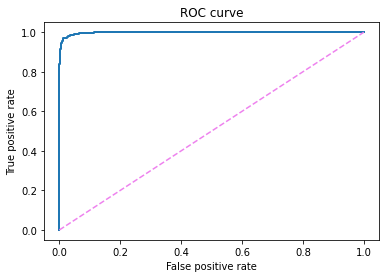

In [21]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_proba))

### K nearest neighbors

In [22]:
knn = KNeighborsClassifier(n_neighbors=1)

In [23]:
knn.fit(X_train_base_scaled,y_train_base)

KNeighborsClassifier(n_neighbors=1)

In [24]:
knn.score(X_test_base_scaled, y_test_base)

0.9235880398671097

In [25]:
pred_knn = knn.predict(X_test_base_scaled)

In [26]:
print(confusion_matrix(y_test_base, pred_knn))

[[648  32]
 [ 60 464]]


In [27]:
print(classification_report(y_test_base, pred_knn))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       680
           1       0.94      0.89      0.91       524

    accuracy                           0.92      1204
   macro avg       0.93      0.92      0.92      1204
weighted avg       0.92      0.92      0.92      1204



#### Choosing a K value

In [28]:
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_base_scaled,y_train_base)
    pred_i = knn.predict(X_test_base_scaled)
    error_rate.append(np.mean(pred_i != y_test_base))

Text(0, 0.5, 'Error Rate')

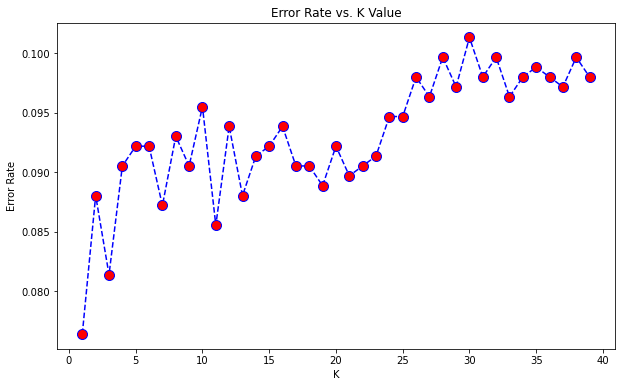

In [29]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

#### Gridsearch

In [30]:
param_grid = {'n_neighbors': list(range(1,11)), 'weights': ['uniform', 'distance'], 'metric': ['euclidean','manhattan']} 

In [31]:
grid = GridSearchCV(KNeighborsClassifier(),param_grid,refit=True,n_jobs=-1,verbose=2)

In [32]:
grid.fit(X_train_base_scaled,y_train_base)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.1s finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [33]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

In [34]:
grid.score(X_test_base_scaled, y_test_base)

0.9385382059800664

In [35]:
grid_pred = grid.predict(X_test_base_scaled)

In [36]:
print(confusion_matrix(y_test_base, grid_pred))

[[656  24]
 [ 50 474]]


In [37]:
print(classification_report(y_test_base, grid_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       680
           1       0.95      0.90      0.93       524

    accuracy                           0.94      1204
   macro avg       0.94      0.93      0.94      1204
weighted avg       0.94      0.94      0.94      1204



In [38]:
grid_pred_proba = grid.predict_proba(X_test_base_scaled)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_proba)

ROC AUC score =  0.9672288953749438


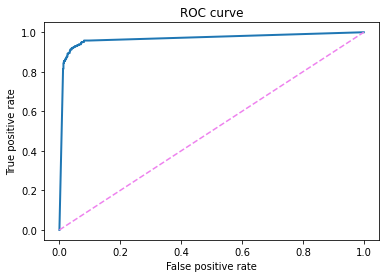

In [39]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_proba))

### Decision Tree 

In [40]:
dtree = DecisionTreeClassifier()

In [41]:
dtree.fit(X_train_base,y_train_base)

DecisionTreeClassifier()

In [42]:
dtree.score(X_test_base, y_test_base)

0.9617940199335548

In [43]:
pred_dtree = dtree.predict(X_test_base)

In [44]:
print(confusion_matrix(y_test_base, pred_dtree))

[[666  14]
 [ 32 492]]


In [45]:
print(classification_report(y_test_base, pred_dtree))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       680
           1       0.97      0.94      0.96       524

    accuracy                           0.96      1204
   macro avg       0.96      0.96      0.96      1204
weighted avg       0.96      0.96      0.96      1204



#### Gridsearch

In [46]:
param_grid = {'criterion': ['gini','entropy'], 'max_depth': range(1,10), 'min_samples_split': range(1,5), 'min_samples_leaf': range(1,5)} 

In [47]:
grid = GridSearchCV(DecisionTreeClassifier(),param_grid,refit=True,n_jobs=-1,verbose=2)

In [48]:
grid.fit(X_train_base,y_train_base)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1357 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.8s finished


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 5)},
             verbose=2)

In [49]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [50]:
grid.score(X_test_base, y_test_base)

0.9700996677740864

In [51]:
grid_pred = grid.predict(X_test_base)

In [52]:
print(confusion_matrix(y_test_base, grid_pred))

[[661  19]
 [ 17 507]]


In [53]:
print(classification_report(y_test_base, grid_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       680
           1       0.96      0.97      0.97       524

    accuracy                           0.97      1204
   macro avg       0.97      0.97      0.97      1204
weighted avg       0.97      0.97      0.97      1204



In [54]:
grid_pred_proba = grid.predict_proba(X_test_base)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_proba)

ROC AUC score =  0.9776507072294567


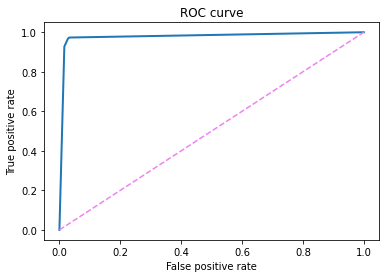

In [55]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_proba))

### Random forest

In [56]:
rfc = RandomForestClassifier()

In [57]:
rfc.fit(X_train_base, y_train_base)

RandomForestClassifier()

In [58]:
rfc.score(X_test_base, y_test_base)

0.957641196013289

In [59]:
pred_rfc = rfc.predict(X_test_base)

In [60]:
print(confusion_matrix(y_test_base, pred_rfc))

[[664  16]
 [ 35 489]]


In [61]:
print(classification_report(y_test_base, pred_rfc))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       680
           1       0.97      0.93      0.95       524

    accuracy                           0.96      1204
   macro avg       0.96      0.95      0.96      1204
weighted avg       0.96      0.96      0.96      1204



#### Gridsearch

In [62]:
param_grid = {'bootstrap': [False],
              'max_depth': [80, 100, 120],
              'max_features': ['auto'],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 3],
              'n_estimators': [550, 600, 650]
             }

In [63]:
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,n_jobs=-1,verbose=2)

In [64]:
grid.fit(X_train_base,y_train_base)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   59.2s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [100, 150],
                         'max_features': ['auto'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [600, 650, 700]},
             verbose=2)

In [65]:
grid.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

In [66]:
grid.score(X_test_base, y_test_base)

0.9584717607973422

In [67]:
grid_pred = grid.predict(X_test_base)

In [68]:
print(confusion_matrix(y_test_base, grid_pred))

[[667  13]
 [ 37 487]]


In [69]:
print(classification_report(y_test_base, grid_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       680
           1       0.97      0.93      0.95       524

    accuracy                           0.96      1204
   macro avg       0.96      0.96      0.96      1204
weighted avg       0.96      0.96      0.96      1204



In [70]:
grid_pred_proba = grid.predict_proba(X_test_base)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_proba)

ROC AUC score =  0.9957692523574315


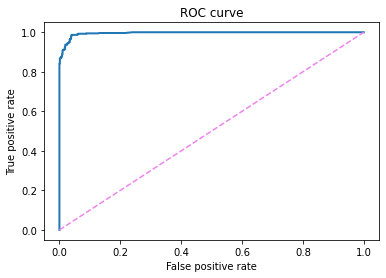

In [71]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_proba))

### Support Vector Machine

In [72]:
svc = SVC()

In [73]:
svc.fit(X_train_base_scaled,y_train_base)

SVC()

In [74]:
svc.score(X_test_base_scaled, y_test_base)

0.9543189368770764

In [75]:
pred_svc = svc.predict(X_test_base_scaled)

In [76]:
print(confusion_matrix(y_test_base, pred_svc))

[[658  22]
 [ 33 491]]


In [77]:
print(classification_report(y_test_base, pred_svc))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       680
           1       0.96      0.94      0.95       524

    accuracy                           0.95      1204
   macro avg       0.95      0.95      0.95      1204
weighted avg       0.95      0.95      0.95      1204



#### Gridsearch

In [78]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [79]:
grid = GridSearchCV(SVC(),param_grid,refit=True,n_jobs=-1,verbose=2)

In [80]:
grid.fit(X_train_base_scaled,y_train_base)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    4.3s finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=2)

In [81]:
grid.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

In [82]:
grid.score(X_test_base_scaled, y_test_base)

0.979235880398671

In [83]:
grid_pred = grid.predict(X_test_base_scaled)

In [84]:
print(confusion_matrix(y_test_base, grid_pred))

[[671   9]
 [ 16 508]]


In [85]:
print(classification_report(y_test_base, grid_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       680
           1       0.98      0.97      0.98       524

    accuracy                           0.98      1204
   macro avg       0.98      0.98      0.98      1204
weighted avg       0.98      0.98      0.98      1204



In [86]:
grid_pred_dec = grid.decision_function(X_test_base_scaled)
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_dec)

ROC AUC score =  0.9981224741805119


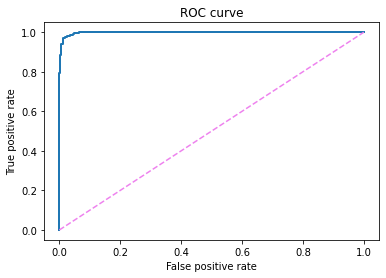

In [87]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_dec))

### Naive Bayes

In [88]:
nb = GaussianNB()

In [89]:
nb.fit(X_train_base, y_train_base)

GaussianNB()

In [90]:
nb.score(X_test_base, y_test_base)

0.6312292358803987

In [91]:
pred_nb = nb.predict(X_test_base)

In [92]:
print(confusion_matrix(y_test_base, pred_nb))

[[635  45]
 [399 125]]


In [93]:
print(classification_report(y_test_base, pred_nb))

              precision    recall  f1-score   support

           0       0.61      0.93      0.74       680
           1       0.74      0.24      0.36       524

    accuracy                           0.63      1204
   macro avg       0.67      0.59      0.55      1204
weighted avg       0.67      0.63      0.58      1204



#### Gridsearch

In [94]:
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

In [95]:
grid = GridSearchCV(GaussianNB(),param_grid,refit=True,n_jobs=-1,verbose=2)

In [96]:
grid.fit(X_train_base,y_train_base)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished


GridSearchCV(estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=2)

In [97]:
grid.best_params_

{'var_smoothing': 6.579332246575682e-07}

In [98]:
grid.score(X_test_base, y_test_base)

0.6262458471760798

In [99]:
grid_pred = grid.predict(X_test_base)

In [100]:
print(confusion_matrix(y_test_base, grid_pred))

[[637  43]
 [407 117]]


In [101]:
print(classification_report(y_test_base, grid_pred))

              precision    recall  f1-score   support

           0       0.61      0.94      0.74       680
           1       0.73      0.22      0.34       524

    accuracy                           0.63      1204
   macro avg       0.67      0.58      0.54      1204
weighted avg       0.66      0.63      0.57      1204



In [102]:
grid_pred_proba = grid.predict_proba(X_test_base)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_proba)

ROC AUC score =  0.6155464189492591


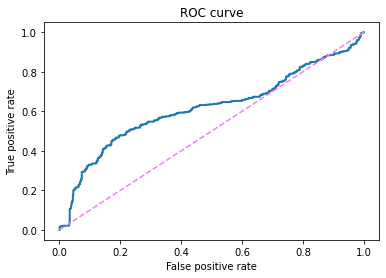

In [103]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_proba))

### XG Boost